<a href="https://colab.research.google.com/github/anushenoyk/FaceMaskDetection-Covid19-/blob/main/Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/face-mask-detector.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/')

In [1]:
%cd /content/drive/My\ Drive/face-mask-detector

[Errno 2] No such file or directory: '/content/drive/My Drive/face-mask-detector'
/content


In [ ]:
%pwd

'/content/drive/My Drive/face-mask-detector'

In [ ]:
!python train_mask_detector.py --dataset dataset

2020-07-08 06:19:56.319831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
[INFO] loading images...
2020-07-08 06:20:09.260824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-08 06:20:09.307573: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-07-08 06:20:09.307657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (532840286f58): /proc/driver/nvidia/version does not exist
2020-07-08 06:20:09.328576: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-07-08 06:20:09.328931: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1c912c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-08 06:20:09

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


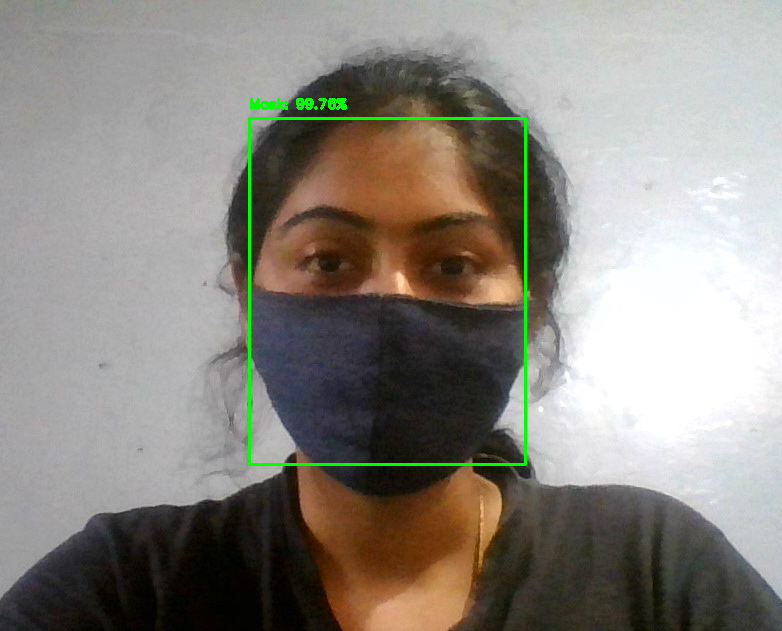

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/My Drive/face-mask-detector/examples/anu.png"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/face-mask-detector/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

def process_images(input_file_path):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	# orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

	# show the output image
	save_path = input_file_path.split(".",1)
	# print (save_path[0])
	# print (save_path[-1])
	cv2_imshow(image)
	# cv2.imwrite(save_path[0] + "_pred." + save_path[-1],image)

#start the process
process_images(input_file_path)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

# input_file_path = "/content/drive/My Drive/my_projects/face_mask_detector/testSet/pic7.jpg"
input_folder_path = "/content/drive/My Drive/face-mask-detector/examples/"
output_folder_path = "/content/drive/My Drive/face-mask-detector/test_OUTPUT.mp4"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/face-mask-detector/face_detector/deploy.prototxt"
weightsPath = "/content/drive/My Drive/face-mask-detector/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

img_array = []

def process_images(input_file_path,count):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	# print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()
	

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 5)

	# show the output image
	
	# cv2_imshow(image)
	height, width, layers = image.shape
	size = (width,height)
	img_array.append(image)
	# resized_frame = cv2.resize(image, (400, 225))
	count+=1
	# video.write(resized_frame)
	print ("\r[INFO] Count: {}".format(count),end='')
	return size, count
	# cv2.imwrite(save_path,image)

#start the process
x = os.listdir(input_folder_path)
sorted_path = natsorted(x, key=lambda y: y.lower())
count = 0
print ("[INFO] Total files: {}".format(len(x)))
for k in sorted_path: 
 file_path = input_folder_path + k
 print ("\r[INFO] File name: {}".format(file_path))
 size, count = process_images(file_path,count)

print ("\n[INFO] Total count/frames: {}".format(count))

#Saving all output frames as MP4 video
print ("[INFO] Saving video")
video = cv2.VideoWriter(output_folder_path, cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] Total files: 4
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/anu.png
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_01.png
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_02.png
[INFO] File name: /content/drive/My Drive/face-mask-detector/examples/example_03.png
[INFO] Count: 4
[INFO] Total count/frames: 4
[INFO] Saving video
[INFO] process complete.
